In [1]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import scipy
# import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sktree.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve



In [12]:
SIMULATIONS = {
    "1" : {"m_factor" : 5},
    "2" : {"m_factor" : 1},
}

SAMP_SIZES = [2**i for i in range(6, 11)]
SAMP_SIZES_plot = [2*2**i for i in range(6, 11)]
REPS = range(100, 1000)
P = 2048
SAVE_PATH  = '/Users/baiyuxin/Desktop/JHU/NDD/Cancer/paper_trunk'

In [3]:
n_jobs = -3
n_estimators = 2000

In [4]:
def sensitivity_at_specificity(y_true, y_score, target_specificity=0.98, pos_label=1):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score_binary, pos_label=pos_label)

    # Find the threshold corresponding to the target specificity
    index = max(np.argmax(fpr > (1 - target_specificity))-1, 0)
    threshold_at_specificity = thresholds[index]

    # Compute sensitivity at the chosen specificity
    # sensitivity = tpr[index]
    # return sensitivity

    # Use the threshold to classify predictions
    y_pred_at_specificity = (y_score_binary >= threshold_at_specificity).astype(int)

    # Compute sensitivity at the chosen specificity
    sensitivity = np.sum((y_pred_at_specificity == 1) & (y_true == 1)) / np.sum(
        y_true == 1
    )

    return sensitivity

In [5]:
SAMP_SIZES = [2**i for i in range(6, 11)]
Reps = 50

In [7]:
# S98_array = np.zeros((Reps,len(SAMP_SIZES)))
for i in range(2,5):
    S98 = []
    for n in SAMP_SIZES:
        est = HonestForestClassifier(
        n_estimators=2000,
        max_samples=1.6,
        max_features=0.3,
        bootstrap= True,
        random_state= 3*i+n,
        tree_estimator=DecisionTreeClassifier(),
        # max_depth = 1,
        honest_fraction=0.5,
        stratify=True,
        # permute_per_tree=True,
        n_jobs=n_jobs,)

        x,y,mu,cov = make_trunk_classification(n_samples=n, n_dim=2048, **SIMULATIONS["1"],n_informative=256,return_params = True)
        # print(cov[0][0])
        x = np.float32(x)
        y = np.float32(y)
        est,prob = build_hyppo_oob_forest(est,x, y)
        sas98 = sensitivity_at_specificity(y, prob, target_specificity=0.98)
        print(i,n,sas98)
        S98.append(sas98)
    np.savetxt(SAVE_PATH + "/Trunk_1_dim2048_reps{}.csv".format(i), S98, delimiter=",")

    # S98_array[i,:] = S98


2 64 0.90625
2 128 0.984375
2 256 0.9765625
2 512 0.9765625
2 1024 0.984375
3 64 1.0
3 128 1.0
3 256 1.0
3 512 0.984375
3 1024 0.984375
4 64 0.96875
4 128 0.984375
4 256 0.96875
4 512 0.9765625
4 1024 0.984375


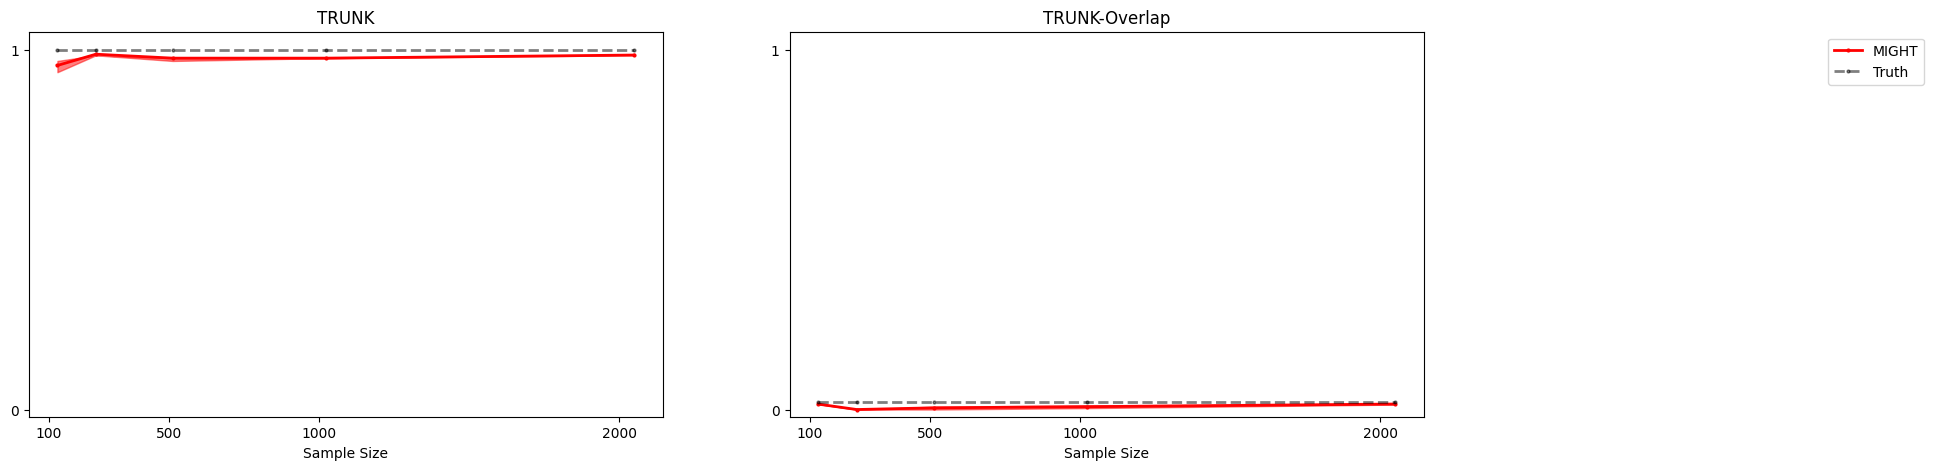

In [16]:
REPs = 5
STATS_S98_TRUNK = np.zeros((REPs,len(SAMP_SIZES)))
STATS_S98_TRUNKOVERLAP = np.zeros((REPs,len(SAMP_SIZES)))
for k in range(REPs):
    for p in SAMP_SIZES:
        s98 = np.genfromtxt(SAVE_PATH + "/Trunk_1_dim2048_reps{}.csv".format(k),delimiter=',')
        s98_over = np.genfromtxt(SAVE_PATH + "/Trunk_overlap_reps{}.csv".format(k),delimiter=',')
    STATS_S98_TRUNK[k,:] = s98
    STATS_S98_TRUNKOVERLAP[k,:] = s98_over

median_MIGHT_TRUNK = np.quantile(STATS_S98_TRUNK, 0.5, axis=0)
mean_MIGHT_TRUNK = np.mean(STATS_S98_TRUNK,axis = 0)
q25_MIGHT_TRUNK = np.quantile(STATS_S98_TRUNK, 0.25, axis=0)
q75_MIGHT_TRUNK = np.quantile(STATS_S98_TRUNK, 0.75, axis=0)

median_MIGHT_TRUNKOVERLAP = np.quantile(STATS_S98_TRUNKOVERLAP, 0.5, axis=0)
mean_MIGHT_TRUNKOVERLAP = np.mean(STATS_S98_TRUNKOVERLAP,axis = 0)
q25_MIGHT_TRUNKOVERLAP = np.quantile(STATS_S98_TRUNKOVERLAP, 0.25, axis=0)
q75_MIGHT_TRUNKOVERLAP = np.quantile(STATS_S98_TRUNKOVERLAP, 0.75, axis=0)




fig, axs = plt.subplots(1, 2,figsize=(18, 5))
axs[0].plot(SAMP_SIZES_plot,mean_MIGHT_TRUNK,
                        'r',marker='o', markersize=2,label = 'MIGHT',linewidth =2)
axs[0].fill_between(SAMP_SIZES_plot,q25_MIGHT_TRUNK,q75_MIGHT_TRUNK,
                                alpha = 0.5,color ='red')
axs[0].plot(SAMP_SIZES_plot, 0.9983 * np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Truth",linewidth =2,alpha = 0.5)
axs[0].set_title("TRUNK")

axs[1].plot(SAMP_SIZES_plot,mean_MIGHT_TRUNKOVERLAP,
                        'r',marker='o', markersize=2,label = 'MIGHT',linewidth =2)
axs[1].fill_between(SAMP_SIZES_plot,q25_MIGHT_TRUNKOVERLAP,q75_MIGHT_TRUNKOVERLAP,
                                alpha = 0.5,color ='red')
axs[1].plot(SAMP_SIZES_plot, 0.02 * np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Truth",linewidth =2,alpha = 0.5)
axs[1].set_title("TRUNK-Overlap")


# axs[2].set_title("Independent")

# axs[2].plot(SAMP_SIZES_plot, 0.02 * np.ones(len(SAMP_SIZES_plot)) , 'black',linestyle='dashed',marker='o', markersize=2,label = "Truth",linewidth =2,alpha = 0.5)
# axs[2].plot(SAMP_SIZES_plot,mean_MIGHT_TRUNKOVERLAP,
#                         'r',marker='o', markersize=2,label = 'MIGHT',linewidth =4,alpha  = 0)
# axs[2].fill_between(SAMP_SIZES_plot,q25_MIGHT_TRUNKOVERLAP,q75_MIGHT_TRUNKOVERLAP,
#                                 alpha = 0.5,color ='red')
axs[1].legend(bbox_to_anchor = (1.8,1),loc = 'upper right')

for sim in ["1","2"]:
    axs[int(sim)-1].set_ylim(-0.02, 1.05)
    axs[int(sim)-1].set_yticks([])
    axs[int(sim)-1].set_xticks([])
    axs[int(sim)-1].set_yticks([0, 1])
    axs[int(sim)-1].set_xticks([100,500,1000,2000])
    axs[int(sim)-1].set_xlabel("Sample Size")

